In [13]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any
#from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib
matplotlib.rc('font', family='Noto Sans CJK JP')
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
np.random.seed(42)
warnings.simplefilter("ignore")

In [10]:
from sklearn.model_selection import train_test_split

def generate_simulation_data(N, beta, mu, sigma):
    """

    :param N:インスタンスの長さ
    :param beta: 各特徴量の傾き
    :param mu: 各特徴量は多変量正規分布から生成される。その平均
    :param sigma: 各特徴量は多変量正規分布から生成される。その分散共分散行列
    :return: train test split data,(X_train, X_test, y_train, y_test)
    """
    X = np.random.multivariate_normal(mu, sigma, N)
    epsilon = np.random.normal(0, 0.1, N)

    y = X @ beta + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)

N = 1000
J = 3
mu = np.zeros(J)
sigma = np.array([[1,0,0], [0,1,0], [0,0,1]])
beta = np.array([0,1,2])
X_train ,X_test, y_train, y_test = generate_simulation_data(N, beta, mu, sigma)

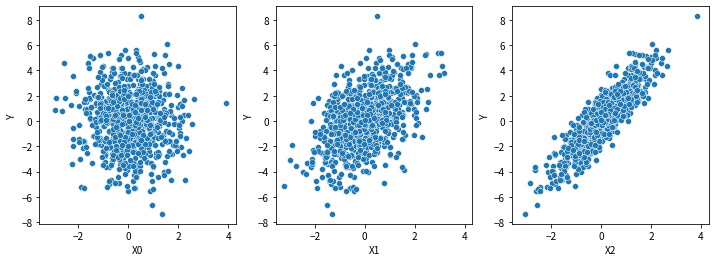

In [15]:
def plot_scatter(X, y, var_names):
    """目的変数と特徴量の散布図を作成"""
    J = X.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(4*J,4))

    for d, ax in enumerate(axes):
        sns.scatterplot(X[:,d], y, alpha=1, ax=ax)
        ax.set(
            xlabel=var_names[d],
            ylabel="Y",
            xlim=(X.min()*1.1, X.max()*1.1)
        )
    fig.show()

var_names = [f"X{j}" for j in range(J)]
plot_scatter(X_train, y_train, var_names)

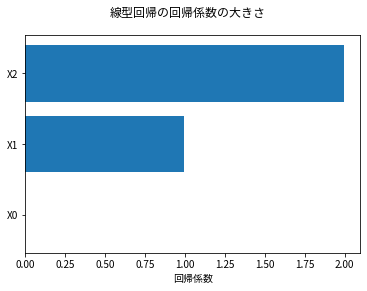

In [18]:
## 線形回帰モデル
from sklearn.linear_model import LinearRegression

def plot_bar(variables, values, title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots()
    ax.barh(variables, values)
    ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,None))
    fig.suptitle(title)
    fig.show()

lm = LinearRegression()
lm.fit(X_train, y_train)
plot_bar(var_names, lm.coef_, "線型回帰の回帰係数の大きさ", "回帰係数")

In [25]:
from sklearn.metrics import mean_squared_error

@dataclass
class PermutationFeatureImportance:
    estimator:Any
    X:np.ndarray
    y:np.ndarray
    var_names:list

    def __post_init__(self) ->None:
        self.baseline = mean_squared_error(
            self.y, self.estimator.predict(self.X), squared=False
        )

    def _permutation_metrics(self, idx_to_permute: int) -> float:
        """

        :param idx_to_permute: シャッフルした特徴量のidx
        :return:
        """
        X_permuted = self.X.copy()

        X_permuted[:, idx_to_permute] = np.random.permutation(
            X_permuted[:, idx_to_permute]
        )
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared=False)

    def permutation_feature_importance(self, n_shuffle: int=10) -> 10:
        """

        :param n_shuffle: default =10
        :return:
        """

        J = self.X.shape[1]

        metrics_permuted = [
            np.mean(
                [self._permutation_metrics(j) for r in range(n_shuffle)]
            )
            for j in range(J)
        ]

        # dfとしてまとめる
        # シャッフルでどれくらい精度が落ちるかは差分と比率の2パターンで評価する

        df_feature_importance = pd.DataFrame(
            data={
                "var_name": self.var_names,
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted / self.baseline
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )

    def plot(self, importance_type: str = "difference") -> None:
        """

        :param self:
        :param importance_type: difference, or ratio
        :return:
        """

        fig, ax = plt.subplots()
        ax.barh(
            self.feature_importance["var_name"],
            self.feature_importance[importance_type],
            label=f"baseline: {self.baseline:.2f}"
        )
        ax.set(xlabel=importance_type,ylabel=None)
        ax.invert_yaxis()
        ax.legend()
        fig.suptitle(f"Permutationによる特徴量の重要度({importance_type})")

        fig.show()

In [26]:
## rf での適用
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print(f"R2: {r2_score(y_test, rf.predict(X_test)):.2f}")

R2: 0.99


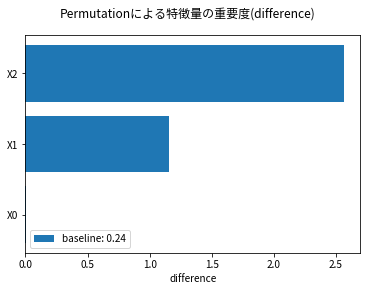

In [27]:
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)

pfi.permutation_feature_importance()
pfi.plot(importance_type="difference")